In [1]:
from google.colab import drive
drive.mount('/content/drive')

!cp /content/drive/MyDrive/6888/project/tomatoAll.zip /content
!unzip /content/tomatoAll.zip

Streaming output truncated to the last 5000 lines.
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/253ddc99-8132-4710-bb89-eb83ab271abc___Matt.S_CG 0698.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/25592188-309d-450c-b45f-fbbdb02b316f___Matt.S_CG 6181.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/2567c820-aa63-490c-8e47-921b85164728___Matt.S_CG 7447.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/256b92d9-41f3-47a4-870f-c0c0f0ac201e___Matt.S_CG 6842.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/25b6cc2a-d883-4e3f-9caa-738e5ec35e30___JR_Sept.L.S 8465.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/25c45a05-4f45-42ad-b18a-b7f694023a31___Matt.S_CG 0824.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/25f7a39f-7fef-4f5d-af4f-cf21934f516a___JR_Sept.L.S 2493.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/261666dc-32fb-43b2-93

In [2]:
!ls tomatoAll

plan-diseases-expert  plant-village


In [20]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, utils, initializers
from tensorflow.keras.preprocessing.image import ImageDataGenerator



base_path = '/content/tomatoAll/'
expert_path = '/content/tomatoAll/plan-diseases-expert'
village_path = '/content/tomatoAll/plant-village'
internet_path = '/content/drive/MyDrive/Colab Notebooks/tomato_images2/'


BATCH_SIZE = 128
IMG_SIZE = (256, 256)
SEED = 42

In [21]:
train_gen, test_gen = tf.keras.utils.image_dataset_from_directory(
    village_path,
    validation_split=0.15,
    subset="both",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)


VALIDATION_SPLIT = 0.15

train_gen = train_gen.take(int((1 - VALIDATION_SPLIT) * len(train_gen)))
valid_gen = train_gen.skip(int((1 - VALIDATION_SPLIT) * len(train_gen)))

valid2_gen, test2_gen = tf.keras.utils.image_dataset_from_directory(
    expert_path,
    seed=SEED,
    validation_split=0.5,
    image_size=IMG_SIZE,
    subset="both",
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)


test3_gen = tf.keras.utils.image_dataset_from_directory(
    internet_path,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

# use cache to improve speed
train_gen = train_gen.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
valid_gen = valid_gen.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_gen = test_gen.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
valid2_gen = valid2_gen.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test2_gen = test2_gen.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test3_gen = test3_gen.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
valid3_gen = test3_gen

Found 12803 files belonging to 9 classes.
Using 10883 files for training.
Using 1920 files for validation.
Found 37455 files belonging to 9 classes.
Using 18728 files for training.
Using 18727 files for validation.
Found 35 files belonging to 9 classes.


In [11]:
from tensorflow.keras.applications import ResNet101, InceptionV3, EfficientNetB1, DenseNet121, VGG16, MobileNetV2, InceptionV3, InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.callbacks import Callback
import time
import matplotlib.pyplot as plt

In [7]:
class TripleValidationCallback(Callback):
    def __init__(self, validation_gen2, validation_gen3):
        super().__init__()
        self.validation_gen2 = validation_gen2
        self.validation_gen3 = validation_gen3
        self.history = {'val2_loss': [], 'val2_acc': [], 'val3_loss': [], 'val3_acc': []}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_loss2, val_acc2 = self.model.evaluate(self.validation_gen2, verbose=0)
        val_loss3, val_acc3 = self.model.evaluate(self.validation_gen3, verbose=0)
        logs['val2_loss'] = val_loss2
        logs['val2_acc'] = val_acc2
        logs['val3_loss'] = val_loss3
        logs['val3_acc'] = val_acc3
        self.history['val2_loss'].append(val_loss2)
        self.history['val2_acc'].append(val_acc2)
        self.history['val3_loss'].append(val_loss3)
        self.history['val3_acc'].append(val_acc3)


In [14]:
def create_and_train_model(base_model, model_filename, freeze_layers=True, epoch=50):

    # Freeze layers
    if freeze_layers:
      for layer in base_model.layers:
          layer.trainable = False

    # GlobalAveragePooling2D layer
    x = GlobalAveragePooling2D()(base_model.output)

    # Modify pre-trained model
    output = Dense(9, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)

    # Compile
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    triple_val_callback = TripleValidationCallback(validation_gen2=valid2_gen, validation_gen3=valid3_gen)

    # Train the model for 50 epochs
    history = model.fit(train_gen, validation_data=valid_gen, epochs=epoch, callbacks=[triple_val_callback])

    # Combine Keras history with custom callback history
    history = history.history
    history.update(triple_val_callback.history)

    # Save the model
    model.save(model_filename)

    # Plotting Losses
    plt.figure()
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation1 Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


    # Plotting Losses
    plt.figure()
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation1 Loss')
    plt.plot(history['val2_loss'], label='Validation2 Loss')
    plt.plot(history['val3_loss'], label='Validation3 Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plotting Accuracies
    plt.figure()
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation1 Accuracy')
    plt.plot(history['val2_acc'], label='Validation2 Accuracy')
    plt.plot(history['val3_acc'], label='Validation3 Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Measure inference time
    start_time = time.time()
    _, accuracy = model.evaluate(test_gen)
    end_time = time.time()
    inference_time = end_time - start_time

    # Measure inference time 2
    start_time = time.time()
    _, accuracy2 = model.evaluate(test2_gen)
    end_time = time.time()
    inference_time2 = end_time - start_time

    # Measure inference time 3
    start_time = time.time()
    _, accuracy3 = model.evaluate(test3_gen)
    end_time = time.time()
    inference_time3 = end_time - start_time

    # Get model size (number of parameters)
    num_params = model.count_params()

    # Print results
    print(f"Model: {model_filename}")
    print(f"Params: {num_params}")
    print(f"Inference Time: {inference_time}")
    print(f"Accuracy: {accuracy}")
    print(f"Inference Time2: {inference_time2}")
    print(f"Accuracy2: {accuracy2}")
    print(f"Inference Time3: {inference_time3}")
    print(f"Accuracy3: {accuracy3}")



Epoch 1/50
36/36 [==============================] - 62s 232ms/step - loss: 0.5745 - accuracy: 0.8046 - val_loss: 1.7442 - val_accuracy: 0.5254 - val2_loss: 1.8584 - val2_acc: 0.4934 - val3_loss: 3.9542 - val3_acc: 0.1429
Epoch 2/50
36/36 [==============================] - 6s 168ms/step - loss: 0.0791 - accuracy: 0.9746 - val_loss: 1.2521 - val_accuracy: 0.6895 - val2_loss: 1.2243 - val2_acc: 0.6686 - val3_loss: 3.6265 - val3_acc: 0.2857
Epoch 3/50
36/36 [==============================] - 6s 169ms/step - loss: 0.0279 - accuracy: 0.9918 - val_loss: 0.3026 - val_accuracy: 0.9043 - val2_loss: 0.4540 - val2_acc: 0.8708 - val3_loss: 4.2235 - val3_acc: 0.3143
Epoch 4/50
36/36 [==============================] - 6s 168ms/step - loss: 0.0162 - accuracy: 0.9944 - val_loss: 0.3862 - val_accuracy: 0.9173 - val2_loss: 0.5965 - val2_acc: 0.8534 - val3_loss: 5.1180 - val3_acc: 0.3714
Epoch 5/50
36/36 [==============================] - 6s 168ms/step - loss: 0.0176 - accuracy: 0.9944 - val_loss: 0.2339 

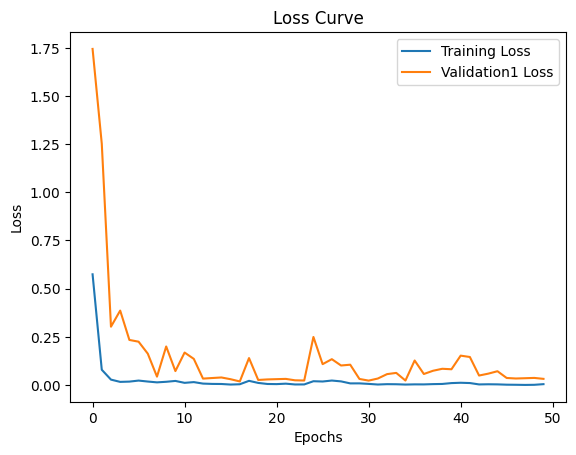

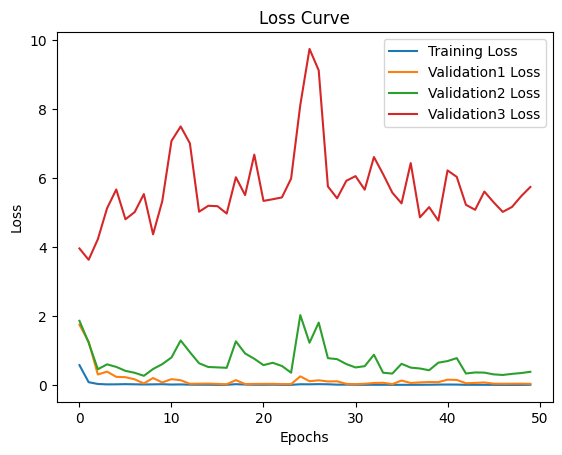

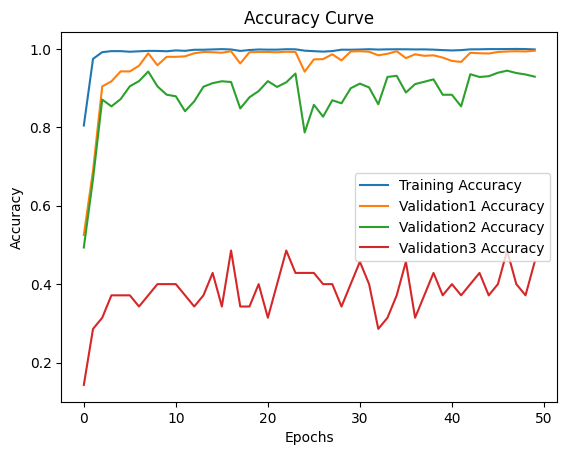

1/1 [==============================] - 0s 23ms/step - loss: 5.7361 - accuracy: 0.4571
Model: /content/drive/MyDrive/Colab Notebooks/effnetB1_tomatoAll_75s_256b_50e.model
Params: 6586768
Inference Time: 0.2543337345123291
Accuracy: 0.9885416626930237
Inference Time2: 2.101644277572632
Accuracy2: 0.9294601082801819
Inference Time3: 0.03312397003173828
Accuracy3: 0.4571428596973419


In [57]:
# Create and train EfficientNetB1 75 256
effnet_base = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
create_and_train_model(effnet_base, '/content/drive/MyDrive/Colab Notebooks/effnetB1_tomatoAll_75s_256b_50e.model', freeze_layers = False)

Epoch 1/50
36/36 [==============================] - 70s 258ms/step - loss: 0.5172 - accuracy: 0.8421 - val_loss: 2084073.8750 - val_accuracy: 0.1478 - val2_loss: 1934094.7500 - val2_acc: 0.1553 - val3_loss: 1137175.3750 - val3_acc: 0.1714
Epoch 2/50
36/36 [==============================] - 7s 200ms/step - loss: 0.0986 - accuracy: 0.9696 - val_loss: 6784.2593 - val_accuracy: 0.1530 - val2_loss: 6145.9360 - val2_acc: 0.1605 - val3_loss: 7086.8989 - val3_acc: 0.1714
Epoch 3/50
36/36 [==============================] - 7s 200ms/step - loss: 0.0452 - accuracy: 0.9850 - val_loss: 33.8006 - val_accuracy: 0.4909 - val2_loss: 28.8288 - val2_acc: 0.4327 - val3_loss: 47.2862 - val3_acc: 0.2571
Epoch 4/50
36/36 [==============================] - 7s 201ms/step - loss: 0.0475 - accuracy: 0.9861 - val_loss: 12.0831 - val_accuracy: 0.6706 - val2_loss: 10.8749 - val2_acc: 0.5557 - val3_loss: 11.5726 - val3_acc: 0.3143
Epoch 5/50
36/36 [==============================] - 7s 202ms/step - loss: 0.0397 - acc

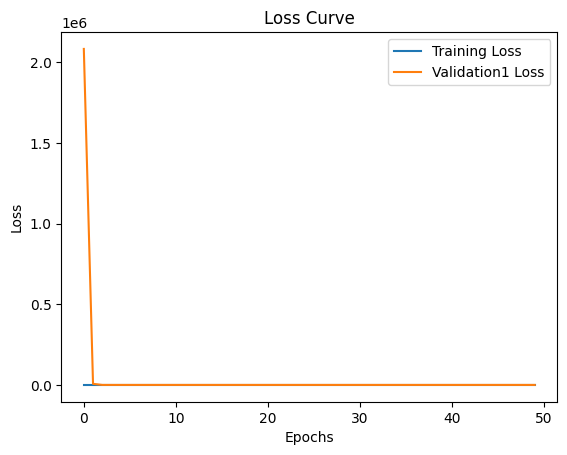

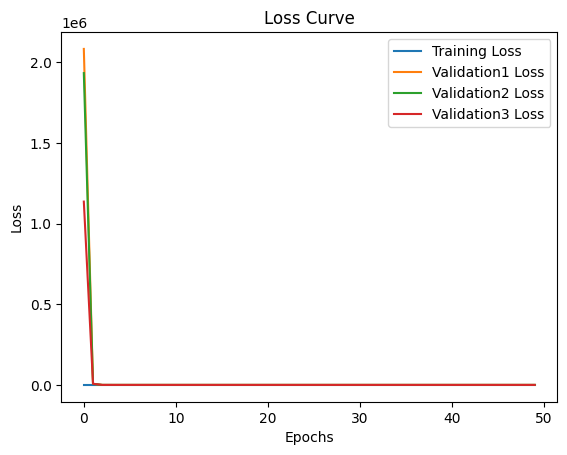

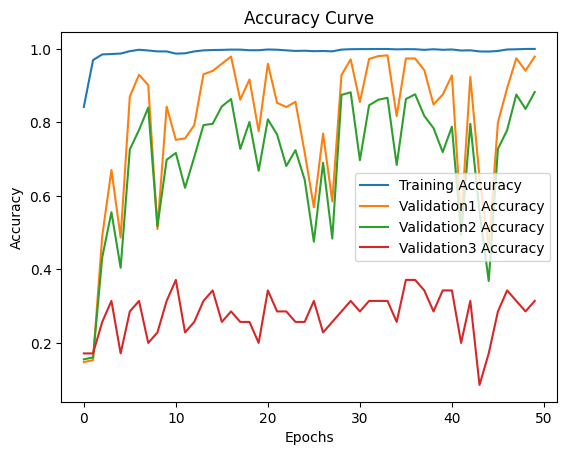

1/1 [==============================] - 0s 29ms/step - loss: 11.2453 - accuracy: 0.3143
Model: /content/drive/MyDrive/Colab Notebooks/resnet101_tomatoAll_75s_256b_50e.model
Params: 42676617
Inference Time: 0.36423540115356445
Accuracy: 0.9489583373069763
Inference Time2: 3.0051162242889404
Accuracy2: 0.8800662159919739
Inference Time3: 0.03965497016906738
Accuracy3: 0.3142857253551483


In [55]:
# Create and train ResNet101 75 256
resnet_base = ResNet101(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
create_and_train_model(resnet_base, '/content/drive/MyDrive/Colab Notebooks/resnet101_tomatoAll_75s_256b_50e.model', freeze_layers=False)

Epoch 1/50
36/36 [==============================] - 61s 224ms/step - loss: 0.5391 - accuracy: 0.8245 - val_loss: 13.7501 - val_accuracy: 0.2285 - val2_loss: 14.4101 - val2_acc: 0.1958 - val3_loss: 25.2789 - val3_acc: 0.0857
Epoch 2/50
36/36 [==============================] - 6s 164ms/step - loss: 0.0889 - accuracy: 0.9702 - val_loss: 5.4780 - val_accuracy: 0.6126 - val2_loss: 7.1848 - val2_acc: 0.5167 - val3_loss: 20.7376 - val3_acc: 0.1429
Epoch 3/50
36/36 [==============================] - 6s 165ms/step - loss: 0.0258 - accuracy: 0.9918 - val_loss: 0.9356 - val_accuracy: 0.8431 - val2_loss: 1.9576 - val2_acc: 0.7321 - val3_loss: 12.8578 - val3_acc: 0.2286
Epoch 4/50
36/36 [==============================] - 6s 162ms/step - loss: 0.0168 - accuracy: 0.9942 - val_loss: 0.7991 - val_accuracy: 0.8581 - val2_loss: 1.3349 - val2_acc: 0.7793 - val3_loss: 9.7553 - val3_acc: 0.3429
Epoch 5/50
36/36 [==============================] - 6s 164ms/step - loss: 0.0112 - accuracy: 0.9971 - val_loss: 0.

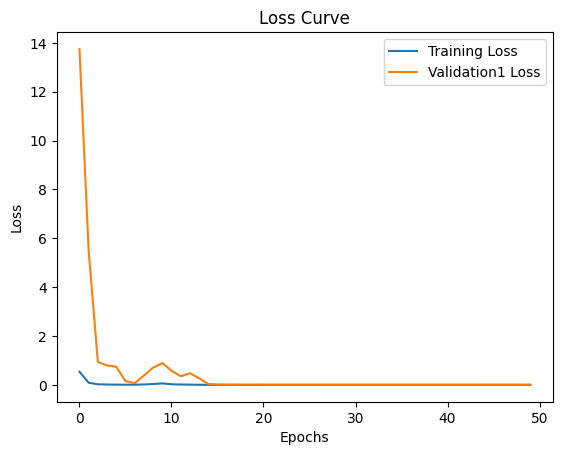

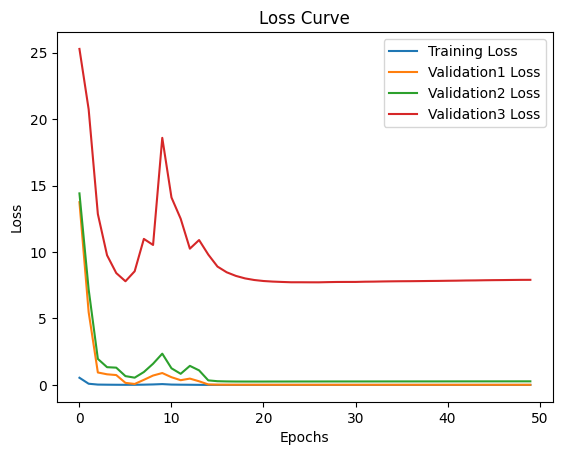

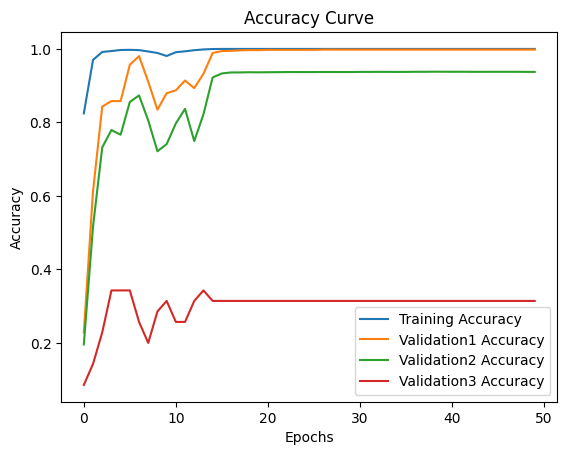

1/1 [==============================] - 0s 26ms/step - loss: 7.9056 - accuracy: 0.3143
Model: /content/drive/MyDrive/Colab Notebooks/densenet121_tomatoAll_75s_256b_50e.model
Params: 7046729
Inference Time: 0.28470659255981445
Accuracy: 0.9895833134651184
Inference Time2: 2.217975616455078
Accuracy2: 0.9402467012405396
Inference Time3: 0.03821134567260742
Accuracy3: 0.3142857253551483


In [54]:
# Create and train DenseNet121 75 256
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
create_and_train_model(densenet_base, '/content/drive/MyDrive/Colab Notebooks/densenet121_tomatoAll_75s_256b_50e.model', freeze_layers=False)

58889256/58889256 [==============================] - 3s 0us/step
Epoch 1/50
 6/36 [====>.........................] - ETA: 1s - loss: 16.1531 - accuracy: 0.1152

36/36 [==============================] - 26s 238ms/step - loss: 4.4880 - accuracy: 0.1492 - val_loss: 2.1404 - val_accuracy: 0.1465 - val2_loss: 2.1338 - val2_acc: 0.1542 - val3_loss: 2.1784 - val3_acc: 0.1714
Epoch 2/50
36/36 [==============================] - 3s 95ms/step - loss: 2.1153 - accuracy: 0.1686 - val_loss: 2.1147 - val_accuracy: 0.2220 - val2_loss: 2.1120 - val2_acc: 0.2314 - val3_loss: 2.2635 - val3_acc: 0.1429
Epoch 3/50
36/36 [==============================] - 3s 94ms/step - loss: 2.0627 - accuracy: 0.2424 - val_loss: 1.9323 - val_accuracy: 0.2539 - val2_loss: 1.9547 - val2_acc: 0.2404 - val3_loss: 2.4899 - val3_acc: 0.2857
Epoch 4/50
36/36 [==============================] - 3s 96ms/step - loss: 1.7718 - accuracy: 0.3336 - val_loss: 1.6011 - val_accuracy: 0.4056 - val2_loss: 1.6282 - val2_acc: 0.3890 - val3_loss: 3.2277 - val3_acc: 0.2000
Epoch 5/50
36/36 [==============================] - 3s 95ms/step - loss: 1.7519 - accuracy: 0.3534 - val_loss: 1.6402 - val_accuracy:

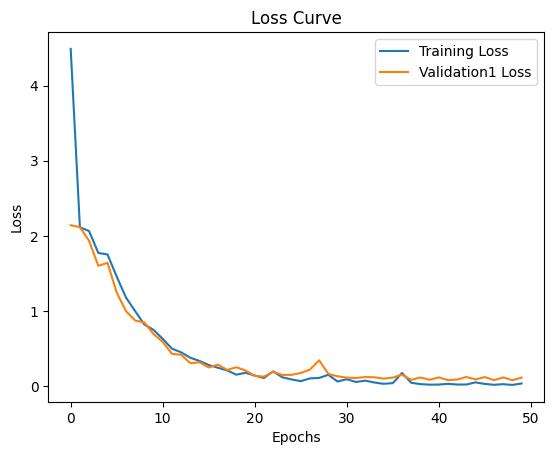

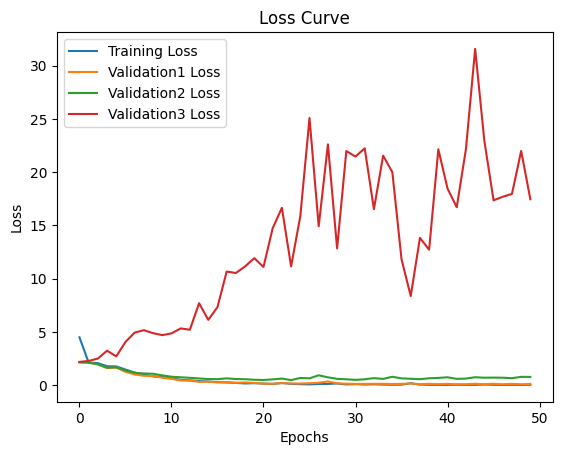

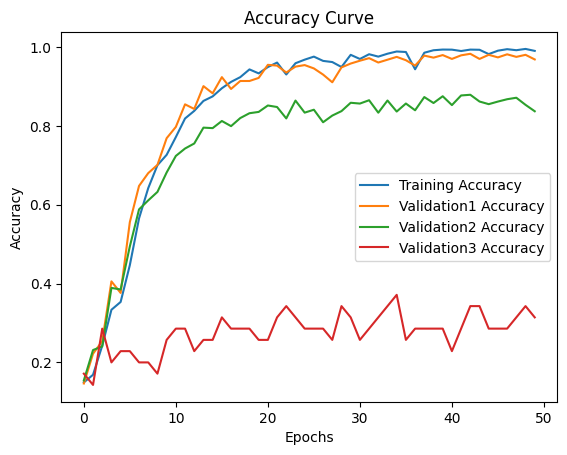

1/1 [==============================] - 0s 14ms/step - loss: 17.4583 - accuracy: 0.3143
Model: /content/drive/MyDrive/Colab Notebooks/vgg16_tomatoAll_75s_256b_50e.model
Params: 14719305
Inference Time: 0.6465811729431152
Accuracy: 0.9239583611488342
Inference Time2: 2.32273006439209
Accuracy2: 0.8401238918304443
Inference Time3: 0.018714189529418945
Accuracy3: 0.3142857253551483


In [9]:
# Create and train VGG16 75 256
densenet_base = VGG16(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
create_and_train_model(densenet_base, '/content/drive/MyDrive/Colab Notebooks/vgg16_tomatoAll_75s_256b_50e.model', freeze_layers=False)

9406464/9406464 [==============================] - 1s 0us/step
Epoch 1/50
36/36 [==============================] - 27s 109ms/step - loss: 0.5709 - accuracy: 0.8105 - val_loss: 12.6284 - val_accuracy: 0.1745 - val2_loss: 12.4665 - val2_acc: 0.1824 - val3_loss: 14.4209 - val3_acc: 0.1143
Epoch 2/50
36/36 [==============================] - 3s 84ms/step - loss: 0.1282 - accuracy: 0.9577 - val_loss: 13.8037 - val_accuracy: 0.1628 - val2_loss: 13.7490 - val2_acc: 0.1751 - val3_loss: 15.6684 - val3_acc: 0.1143
Epoch 3/50
36/36 [==============================] - 3s 82ms/step - loss: 0.0449 - accuracy: 0.9849 - val_loss: 18.9404 - val_accuracy: 0.2461 - val2_loss: 19.1253 - val2_acc: 0.2419 - val3_loss: 25.3266 - val3_acc: 0.0571
Epoch 4/50
36/36 [==============================] - 3s 82ms/step - loss: 0.0229 - accuracy: 0.9919 - val_loss: 15.5457 - val_accuracy: 0.3047 - val2_loss: 16.8109 - val2_acc: 0.2510 - val3_loss: 18.0130 - val3_acc: 0.1143
Epoch 5/50
36/36 [=============================

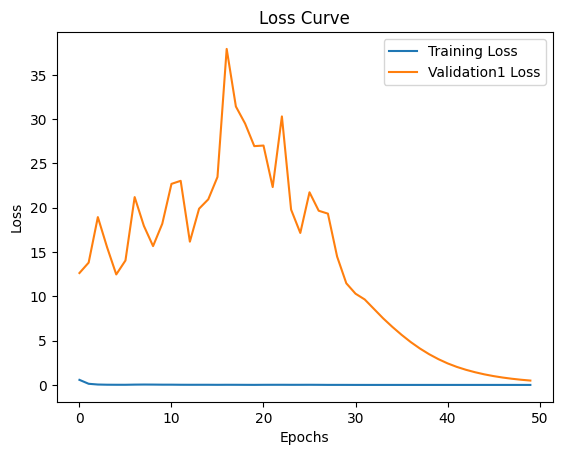

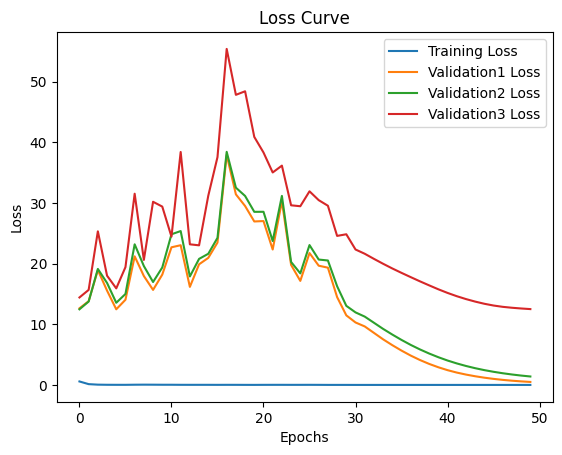

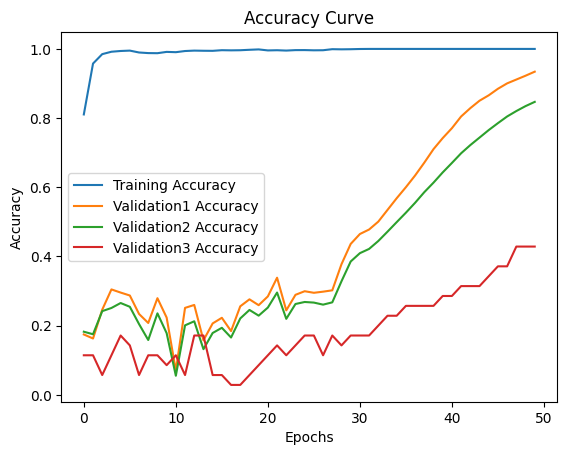

1/1 [==============================] - 0s 19ms/step - loss: 12.5029 - accuracy: 0.4286
Model: /content/drive/MyDrive/Colab Notebooks/mobilenetv2_tomatoAll_75s_256b_50e.model
Params: 2269513
Inference Time: 0.1566152572631836
Accuracy: 0.909375011920929
Inference Time2: 1.1299231052398682
Accuracy2: 0.8380947113037109
Inference Time3: 0.025680065155029297
Accuracy3: 0.4285714328289032


In [10]:
# Create and train MobileNetV2 75 256
densenet_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
create_and_train_model(densenet_base, '/content/drive/MyDrive/Colab Notebooks/mobilenetv2_tomatoAll_75s_256b_50e.model', freeze_layers=False)

Epoch 1/100
36/36 [==============================] - 27s 110ms/step - loss: 0.6006 - accuracy: 0.8038 - val_loss: 16.5152 - val_accuracy: 0.1816 - val2_loss: 16.9648 - val2_acc: 0.1530 - val3_loss: 21.2365 - val3_acc: 0.0286
Epoch 2/100
36/36 [==============================] - 3s 84ms/step - loss: 0.1093 - accuracy: 0.9654 - val_loss: 11.5261 - val_accuracy: 0.1660 - val2_loss: 12.3824 - val2_acc: 0.1426 - val3_loss: 14.4668 - val3_acc: 0.0286
Epoch 3/100
36/36 [==============================] - 3s 84ms/step - loss: 0.0626 - accuracy: 0.9796 - val_loss: 14.5240 - val_accuracy: 0.1660 - val2_loss: 15.6913 - val2_acc: 0.1427 - val3_loss: 17.8171 - val3_acc: 0.0286
Epoch 4/100
36/36 [==============================] - 3s 84ms/step - loss: 0.0386 - accuracy: 0.9890 - val_loss: 16.2331 - val_accuracy: 0.1849 - val2_loss: 17.5878 - val2_acc: 0.1598 - val3_loss: 21.5345 - val3_acc: 0.0286
Epoch 5/100
36/36 [==============================] - 3s 85ms/step - loss: 0.0215 - accuracy: 0.9921 - val_

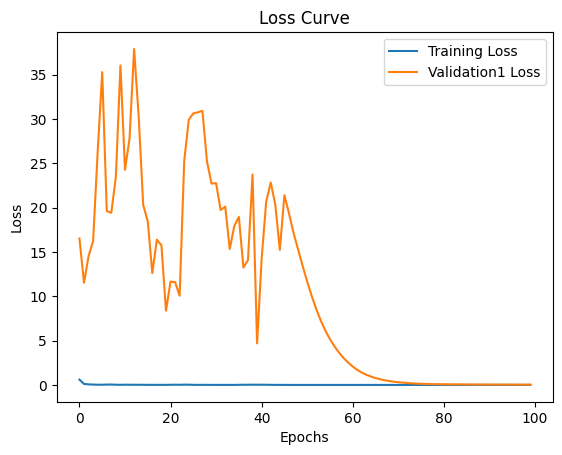

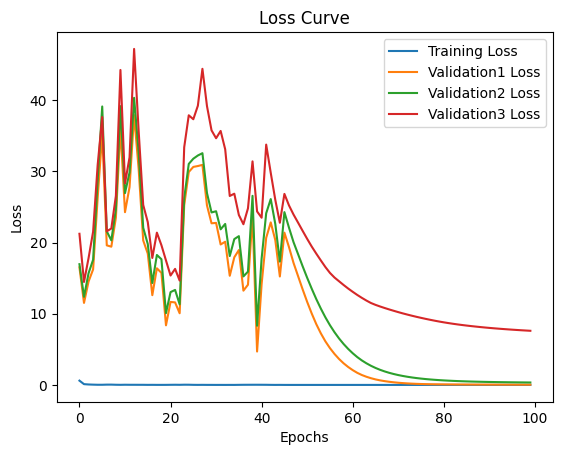

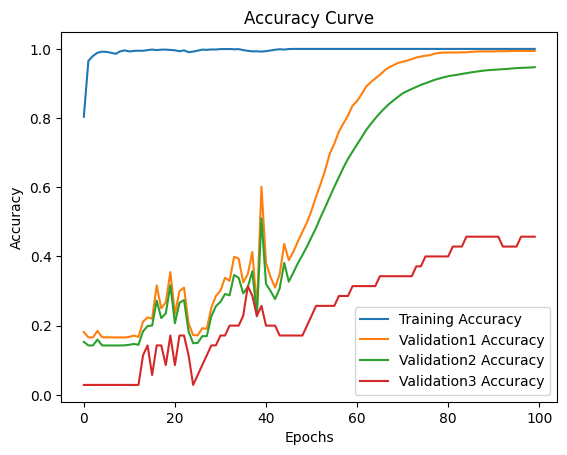

1/1 [==============================] - 0s 14ms/step - loss: 7.6058 - accuracy: 0.4571
Model: /content/drive/MyDrive/Colab Notebooks/mobilenetv2_tomatoAll_75s_256b_100e.model
Params: 2269513
Inference Time: 0.1408839225769043
Accuracy: 0.9822916388511658
Inference Time2: 1.0726532936096191
Accuracy2: 0.9470817446708679
Inference Time3: 0.02008819580078125
Accuracy3: 0.4571428596973419


In [15]:
# Create and train MobileNetV2 75 256
base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
create_and_train_model(base, '/content/drive/MyDrive/Colab Notebooks/mobilenetv2_tomatoAll_75s_256b_100e.model', freeze_layers=False, epoch=100)

Epoch 1/200
36/36 [==============================] - 25s 108ms/step - loss: 0.5573 - accuracy: 0.8166 - val_loss: 12.7395 - val_accuracy: 0.1523 - val2_loss: 13.1904 - val2_acc: 0.1569 - val3_loss: 17.0315 - val3_acc: 0.0857
Epoch 2/200
36/36 [==============================] - 3s 83ms/step - loss: 0.1123 - accuracy: 0.9642 - val_loss: 15.4590 - val_accuracy: 0.1595 - val2_loss: 16.4289 - val2_acc: 0.1649 - val3_loss: 21.6203 - val3_acc: 0.0000e+00
Epoch 3/200
36/36 [==============================] - 3s 83ms/step - loss: 0.0371 - accuracy: 0.9880 - val_loss: 24.5707 - val_accuracy: 0.1686 - val2_loss: 26.2405 - val2_acc: 0.1451 - val3_loss: 30.3812 - val3_acc: 0.0286
Epoch 4/200
36/36 [==============================] - 3s 82ms/step - loss: 0.0259 - accuracy: 0.9907 - val_loss: 24.2369 - val_accuracy: 0.1693 - val2_loss: 25.7671 - val2_acc: 0.1443 - val3_loss: 28.5323 - val3_acc: 0.0286
Epoch 5/200
36/36 [==============================] - 3s 83ms/step - loss: 0.0232 - accuracy: 0.9916 - 

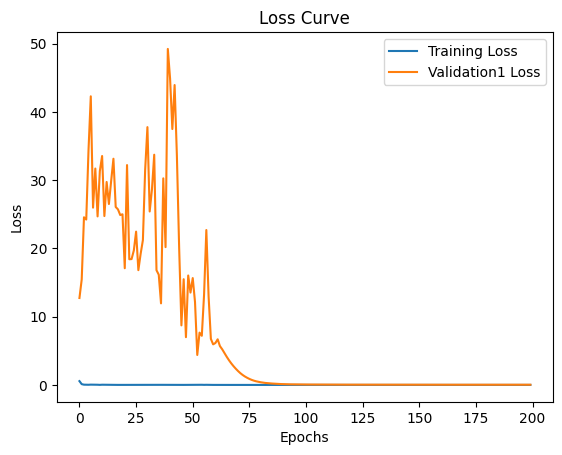

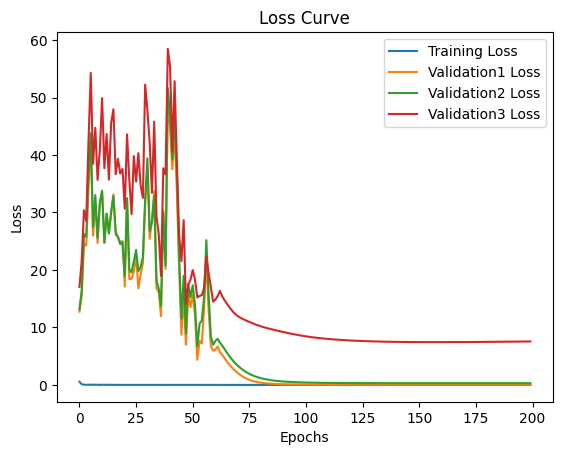

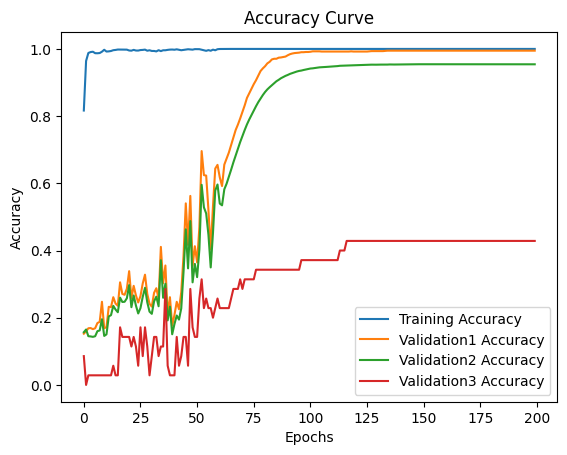

1/1 [==============================] - 0s 14ms/step - loss: 7.5618 - accuracy: 0.4286
Model: /content/drive/MyDrive/Colab Notebooks/mobilenetv2_tomatoAll_75s_256b_200e.model
Params: 2269513
Inference Time: 0.1457829475402832
Accuracy: 0.9869791865348816
Inference Time2: 1.1113319396972656
Accuracy2: 0.9542372226715088
Inference Time3: 0.02050471305847168
Accuracy3: 0.4285714328289032


In [16]:
# Create and train MobileNetV2 75 256
base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
create_and_train_model(base, '/content/drive/MyDrive/Colab Notebooks/mobilenetv2_tomatoAll_75s_256b_200e.model', freeze_layers=False, epoch=200)

Epoch 1/100
73/73 [==============================] - 48s 334ms/step - loss: 0.2918 - accuracy: 0.9050 - val_loss: 28.2633 - val_accuracy: 0.1357 - val2_loss: 28.4670 - val2_acc: 0.1426 - val3_loss: 29.3721 - val3_acc: 0.0286
Epoch 2/100
73/73 [==============================] - 21s 288ms/step - loss: 0.0516 - accuracy: 0.9827 - val_loss: 30.5038 - val_accuracy: 0.1357 - val2_loss: 30.5421 - val2_acc: 0.1426 - val3_loss: 35.5773 - val3_acc: 0.0286
Epoch 3/100
73/73 [==============================] - 21s 289ms/step - loss: 0.0354 - accuracy: 0.9868 - val_loss: 24.5142 - val_accuracy: 0.1470 - val2_loss: 24.9412 - val2_acc: 0.1528 - val3_loss: 26.1131 - val3_acc: 0.0286
Epoch 4/100
73/73 [==============================] - 21s 289ms/step - loss: 0.0393 - accuracy: 0.9872 - val_loss: 27.2166 - val_accuracy: 0.1520 - val2_loss: 26.6489 - val2_acc: 0.1614 - val3_loss: 34.9203 - val3_acc: 0.0286
Epoch 5/100
73/73 [==============================] - 21s 289ms/step - loss: 0.0095 - accuracy: 0.996

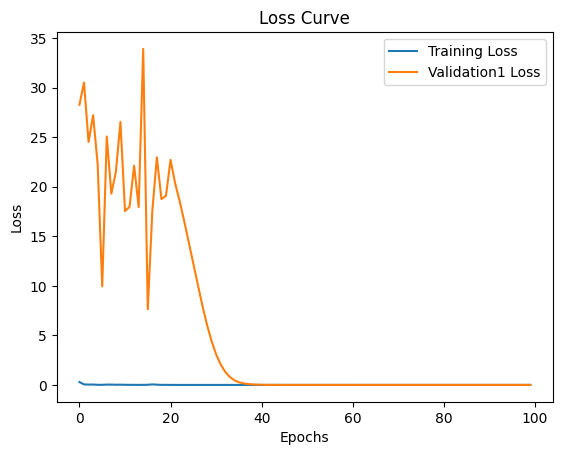

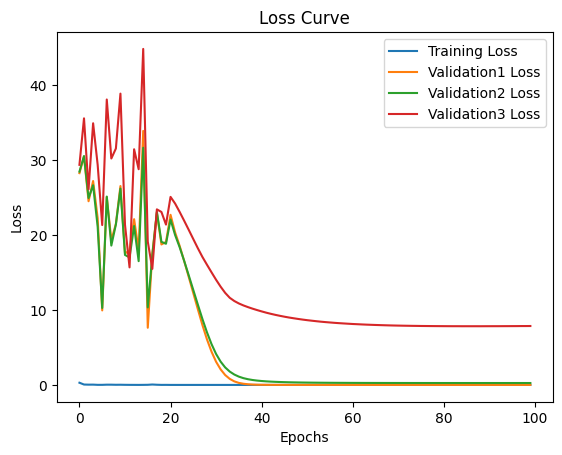

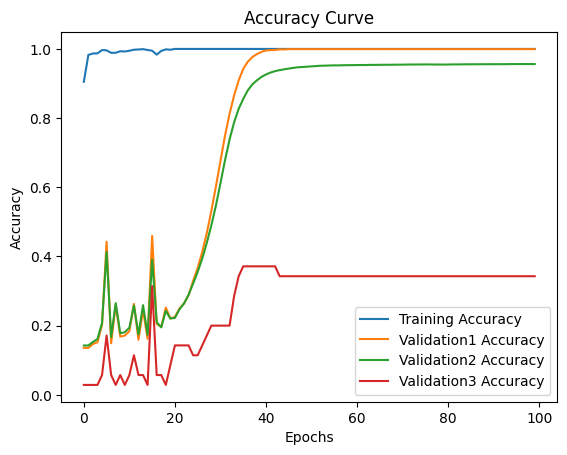

1/1 [==============================] - 0s 28ms/step - loss: 7.8614 - accuracy: 0.3429
Model: /content/drive/MyDrive/Colab Notebooks/mobilenetv2_tomatoAll_256s_128b_200e.model
Params: 2269513
Inference Time: 1.047999620437622
Accuracy: 0.9947916865348816
Inference Time2: 10.078639507293701
Accuracy2: 0.9575479030609131
Inference Time3: 0.035613059997558594
Accuracy3: 0.34285715222358704


In [22]:
# Create and train MobileNetV2 256 128
base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
create_and_train_model(base, '/content/drive/MyDrive/Colab Notebooks/mobilenetv2_tomatoAll_256s_128b_200e.model', freeze_layers=False, epoch=100)

87910968/87910968 [==============================] - 5s 0us/step
Epoch 1/50
36/36 [==============================] - 37s 164ms/step - loss: 1.1360 - accuracy: 0.6280 - val_loss: 2910.6960 - val_accuracy: 0.1478 - val2_loss: 2719.1267 - val2_acc: 0.1553 - val3_loss: 4517.6099 - val3_acc: 0.1714
Epoch 2/50
36/36 [==============================] - 4s 99ms/step - loss: 0.2291 - accuracy: 0.9295 - val_loss: 66.0505 - val_accuracy: 0.1152 - val2_loss: 65.7537 - val2_acc: 0.1252 - val3_loss: 90.1444 - val3_acc: 0.1714
Epoch 3/50
36/36 [==============================] - 4s 99ms/step - loss: 0.0974 - accuracy: 0.9708 - val_loss: 7.9774 - val_accuracy: 0.2357 - val2_loss: 8.9525 - val2_acc: 0.2266 - val3_loss: 8.7162 - val3_acc: 0.2000
Epoch 4/50
36/36 [==============================] - 3s 94ms/step - loss: 0.0659 - accuracy: 0.9801 - val_loss: 1.7811 - val_accuracy: 0.6100 - val2_loss: 2.1369 - val2_acc: 0.5243 - val3_loss: 5.1080 - val3_acc: 0.1714
Epoch 5/50
36/36 [===========================

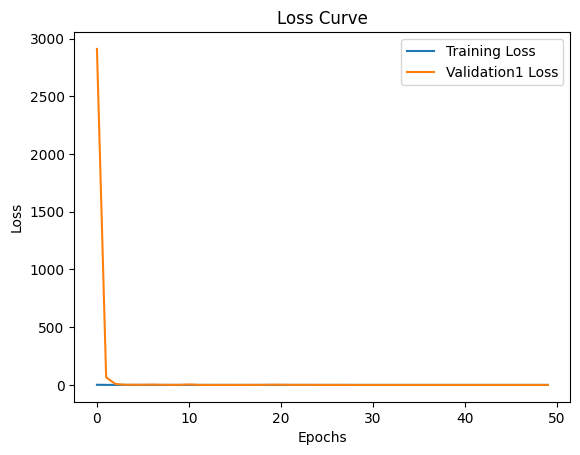

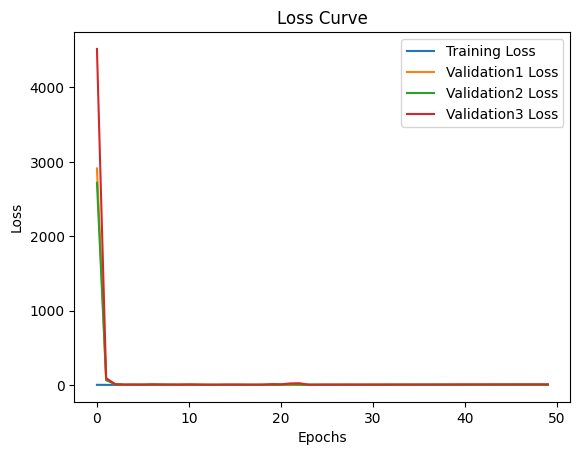

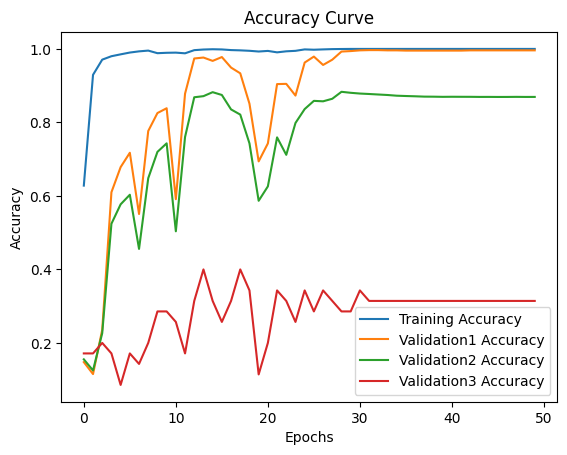

1/1 [==============================] - 0s 23ms/step - loss: 8.7481 - accuracy: 0.3143
Model: /content/drive/MyDrive/Colab Notebooks/inceptionv3_tomatoAll_75s_256b_50e.model
Params: 21821225
Inference Time: 0.5391347408294678
Accuracy: 0.9833333492279053
Inference Time2: 1.5762231349945068
Accuracy2: 0.873337984085083
Inference Time3: 0.03344893455505371
Accuracy3: 0.3142857253551483


In [12]:
# Create and train InceptionV3 75 256
base = InceptionV3(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
create_and_train_model(base, '/content/drive/MyDrive/Colab Notebooks/inceptionv3_tomatoAll_75s_256b_50e.model', freeze_layers=False)

219055592/219055592 [==============================] - 9s 0us/step
Epoch 1/50
36/36 [==============================] - 89s 325ms/step - loss: 0.6096 - accuracy: 0.8025 - val_loss: 450.5381 - val_accuracy: 0.1237 - val2_loss: 507.9684 - val2_acc: 0.1034 - val3_loss: 896.3879 - val3_acc: 0.1714
Epoch 2/50
36/36 [==============================] - 7s 202ms/step - loss: 0.0607 - accuracy: 0.9860 - val_loss: 6.2223 - val_accuracy: 0.3841 - val2_loss: 7.5804 - val2_acc: 0.3343 - val3_loss: 11.0236 - val3_acc: 0.2000
Epoch 3/50
36/36 [==============================] - 7s 200ms/step - loss: 0.0261 - accuracy: 0.9965 - val_loss: 1.6580 - val_accuracy: 0.6921 - val2_loss: 3.1620 - val2_acc: 0.5789 - val3_loss: 9.2780 - val3_acc: 0.2571
Epoch 4/50
36/36 [==============================] - 7s 201ms/step - loss: 0.0106 - accuracy: 0.9984 - val_loss: 0.7158 - val_accuracy: 0.8138 - val2_loss: 1.8130 - val2_acc: 0.6848 - val3_loss: 7.6439 - val3_acc: 0.1714
Epoch 5/50
36/36 [===========================

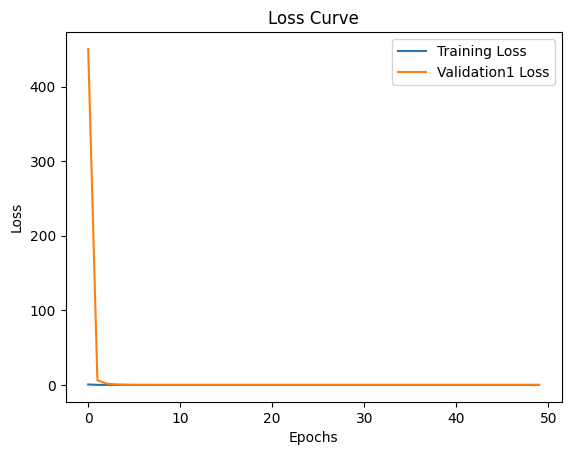

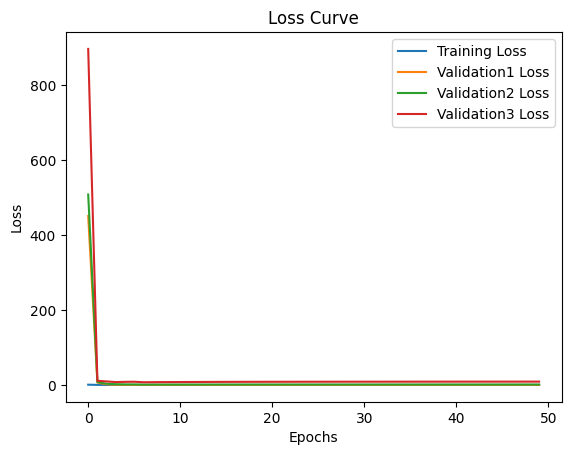

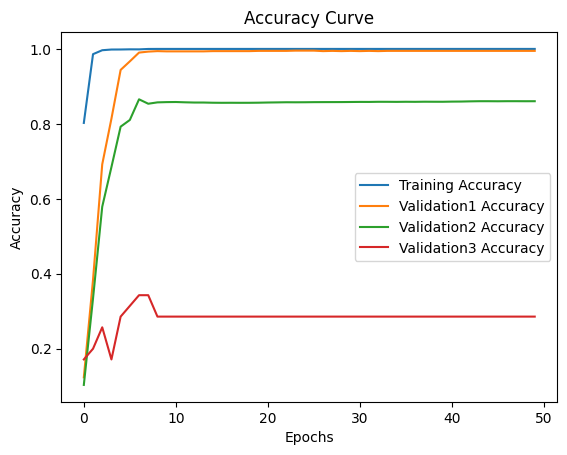

1/1 [==============================] - 0s 36ms/step - loss: 8.8146 - accuracy: 0.2857
Model: /content/drive/MyDrive/Colab Notebooks/inceptionresnetv2_tomatoAll_75s_256b_50e.model
Params: 54350569
Inference Time: 0.4927690029144287
Accuracy: 0.96875
Inference Time2: 2.6431009769439697
Accuracy2: 0.8628184199333191
Inference Time3: 0.053888559341430664
Accuracy3: 0.2857142984867096


In [13]:
# Create and train InceptionResNetV2 75 256
base = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
create_and_train_model(base, '/content/drive/MyDrive/Colab Notebooks/inceptionresnetv2_tomatoAll_75s_256b_50e.model', freeze_layers=False)